In [1]:
from attacker_network import AttackerNetwork
from diffusers import StableDiffusionInstructPix2PixPipeline
from prompt_tuning_attack.src.utils import open_image, display_image
from transformers import AutoImageProcessor, AutoModel
import clip
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

/users/eleves-b/2024/alessandro.pranzo/.pyenv/versions/3.10.15/envs/gen_ai_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
clip_model = clip.load("ViT-L/14", device="cuda")[0]

print("CLIP model loaded")

CLIP model loaded


In [3]:
instruct_pix2pix_model = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix", torch_dtype=torch.float16, safety_checker=None
).to(device)

print("Instruct Pix2Pix model loaded!")

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  7.14it/s]


Instruct Pix2Pix model loaded!


In [4]:
dinov2_model = AutoModel.from_pretrained("facebook/dinov2-small", torch_dtype=torch.float16).to(device)
dinov2_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-small")

print("DINOv2 model & preprocessor loaded!")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


DINOv2 model & preprocessor loaded!


In [5]:
attacker = AttackerNetwork(
    clip_model=clip_model,
    pix2pix_model=instruct_pix2pix_model,
    dinov2_model=dinov2_model,
    dinov2_processor=dinov2_processor,
    device=device,
)

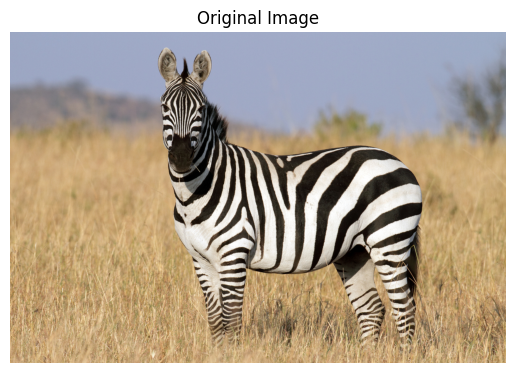

In [6]:
image = open_image("zebra.jpg")

display_image(image, title="Original Image")

In [7]:
modified_feat, original_feat, modified_image = attacker(image)

100%|██████████| 50/50 [00:08<00:00,  5.69it/s]


In [8]:
print(modified_feat.shape)
print(original_feat.shape)


torch.Size([1, 384])
torch.Size([1, 384])


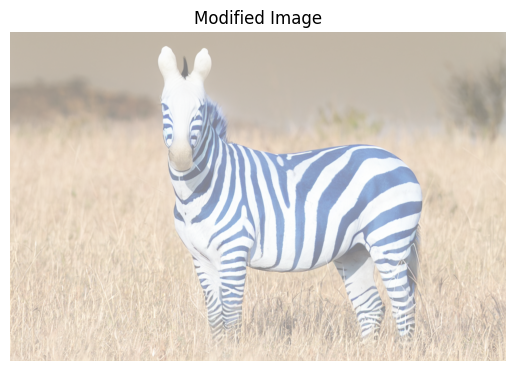

In [9]:
display_image(modified_image, title="Modified Image")

In [10]:
total_params = 0
trainable_params = 0
        
        # Count parameters in all modules
for name, module in attacker.named_modules():
    for param in module.parameters(recurse=False):
        total_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
                    
print(f"Trainable parameters: {trainable_params:,} / {total_params:,} total parameters")
print(f"Percentage of trainable parameters: {100 * trainable_params / total_params:.2f}%")


Trainable parameters: 11,520 / 449,684,609 total parameters
Percentage of trainable parameters: 0.00%
